In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visiondataset/csvTestLabel 3360x1.csv
/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv
/kaggle/input/visiondataset/TrainTest Images Matlab.mat
/kaggle/input/visiondataset/csvTestImages 3360x1024.csv
/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv


## Visualizing Dataset

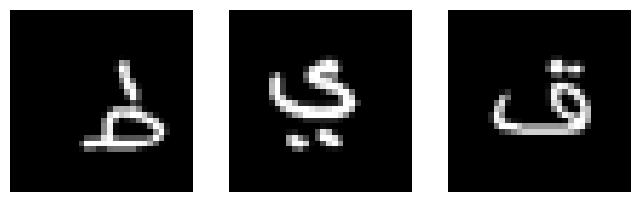

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv')

# Since the CSV is large, we'll only load a few rows for this visualization
df_sample = df.sample(3)

# Convert the sample DataFrame to a numpy array and reshape it to 3 sets of 32x32 images
# Assuming the images are 32x32, which is a common size for small grayscale images.
images = df_sample.to_numpy().reshape(-1, 32, 32)

# Rotate the images by 90 degrees and invert along the y-axis
rotated_images = np.rot90(images, k=1, axes=(1, 2))
mirrored_images = np.flip(rotated_images, axis=1)

# Plot the rotated and mirrored images
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(mirrored_images[i], cmap='gray')
    ax.axis('off')  # Hide the axes ticks
plt.show()


# Task 1

## Model 1

Arabic Handwritten Character Recognition Using
Convolutional Neural Networks
Alhag Alsayed (  alhagalsayed30@gmail.com )
Wuhan University of Technology
Chunlin Li
Wuhan University of Technology
Ahamed Fat’hAlalim
Wuhan University of Technology
Mohammed Abdalsalam
Wuhan University of Technology
Zainab Obied
Wuhan University of Technology

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Record the start time
start_time = time.time()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(image_path, label_path):
    # Load datasets
    images = pd.read_csv(image_path, header=None).values
    labels = pd.read_csv(label_path, header=None).values

    # Reshape images to (num_samples, 1, 32, 32)
    images = images.reshape(-1, 1, 32, 32)

    # Normalize image data
    images = images.astype(np.float32) / 255.0

    # Convert labels to long type and zero-index them
    labels = torch.tensor(labels).long().squeeze()
    labels -= 1  # Subtract 1 if labels start from 1

    return torch.tensor(images), labels

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First block of conv layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Second block of conv layers
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        # Third block of conv layers
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)

        # Fourth block of conv layers with dropout
        self.dropout1 = nn.Dropout(0.5)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, 3, padding=1)

        # Calculate the size of the flattened layer
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1, nn.ReLU(), self.conv2, nn.ReLU(), self.pool,
            self.conv3, nn.ReLU(), self.conv4, nn.ReLU(), self.pool,
            self.conv5, nn.ReLU(), self.conv6, nn.ReLU(), self.pool,
            self.dropout1,
            self.conv7, nn.ReLU(), self.conv8, nn.ReLU(), self.pool
        )
        self._get_conv_output_size([1, 32, 32])  # Example input size

        # Fully connected dense layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 256)

        # Dropout before the output layer
        self.dropout2 = nn.Dropout(0.5)

        # Output layer
        self.fc3 = nn.Linear(256, 28)  # 28 classes

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            input = torch.rand(shape).unsqueeze(0)
            output = self.convs(input)
            self._to_linear = int(np.prod(output.size()[1:]))

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.convs(x)

        # Flatten the output
        x = torch.flatten(x, 1)  # Flatten starting from the 1st dimension

        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Create the model instance
model = CNNModel().to(device)
model

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2

Epoch [1/100], T Loss: 3.3181, T Accuracy: 0.0407, V Loss: 3.1877, V Accuracy: 0.0866
Epoch [2/100], T Loss: 2.6109, T Accuracy: 0.1394, V Loss: 2.1313, V Accuracy: 0.2173
Epoch [3/100], T Loss: 1.9041, T Accuracy: 0.2706, V Loss: 1.5092, V Accuracy: 0.3744
Epoch [4/100], T Loss: 1.4276, T Accuracy: 0.4076, V Loss: 1.1475, V Accuracy: 0.4991
Epoch [5/100], T Loss: 1.1526, T Accuracy: 0.4901, V Loss: 0.9896, V Accuracy: 0.5354
Epoch [6/100], T Loss: 1.0205, T Accuracy: 0.5442, V Loss: 0.8755, V Accuracy: 0.6009
Epoch [7/100], T Loss: 0.8869, T Accuracy: 0.6066, V Loss: 0.6926, V Accuracy: 0.6988
Epoch [8/100], T Loss: 0.7472, T Accuracy: 0.6932, V Loss: 0.5833, V Accuracy: 0.7664
Epoch [9/100], T Loss: 0.6315, T Accuracy: 0.7510, V Loss: 0.5307, V Accuracy: 0.8063
Epoch [10/100], T Loss: 0.5436, T Accuracy: 0.7950, V Loss: 0.4435, V Accuracy: 0.8423
Epoch [11/100], T Loss: 0.4767, T Accuracy: 0.8314, V Loss: 0.3442, V Accuracy: 0.8807
Epoch [12/100], T Loss: 0.3970, T Accuracy: 0.8574, 

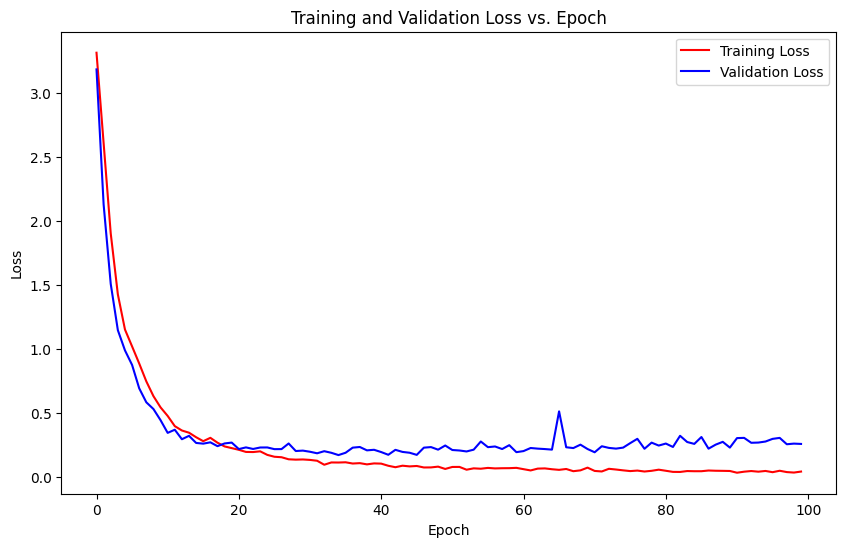

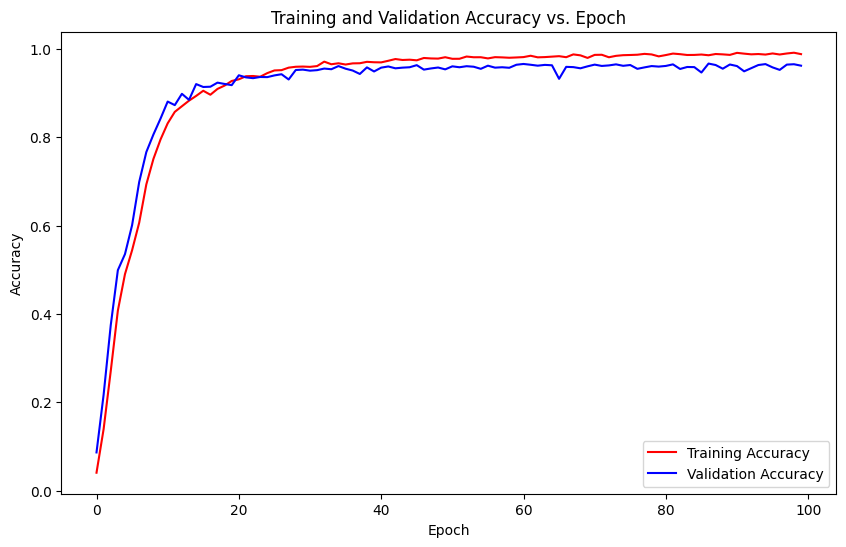

Elapsed time: 151.22227954864502 seconds


In [5]:
# Load and preprocess training data
train_images, train_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv', 
    '/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv'
)

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTestImages 3360x1024.csv', 
    '/kaggle/input/visiondataset/csvTestLabel 3360x1.csv'
)

# Creating data loaders for training and testing data
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to store losses and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    training_accuracies.append(accuracy)
    
    # Evaluating the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_accuracy = 0.0
    total_val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()  # Accumulate validation loss
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        avg_val_loss = total_val_loss / len(test_loader)  # Average validation loss

        validation_losses.append(avg_val_loss)
        validation_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], T Loss: {avg_loss:.4f}, T Accuracy: {accuracy:.4f}, V Loss: {avg_val_loss:.4f}, V Accuracy: {test_accuracy:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies on the same plot
plt.figure(figsize=(10, 6))

plt.plot(training_accuracies, label='Training Accuracy', color='red')
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print('Test accuracy is: {} %'.format(100 * correct / total))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))


Test accuracy is: 96.19047619047619 %
Precision: 0.9631
Recall: 0.9619
F1 Score: 0.9619


## Model 2

Arabic Handwritten Character Recognition based on Convolution Neural Networks and Support Vector Machine
Mahmoud Shams1
Department of Machine Learning and Information Retrieval, Faculty of Artificial Intelligence, Kafrelsheikh University
Kafrelsheikh, Egypt, 33511
Amira. A. Elsonbaty2
Department of electronic and Communication
Higher Institute of Engineering and Technology in New Damietta, Egypt.
Wael. Z. ElSawy3
Department of Business Information System
Faculty of Management Technology & Information System, PortSaid University, Egypt, 42511

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch [1/100], T Loss: 2.5064, T Accuracy: 0.2387, V Loss: 1.3735, V Accuracy: 0.5223
Epoch [2/100], T Loss: 1.1157, T Accuracy: 0.6094, V Loss: 0.7112, V Accuracy: 0.7548
Epoch [3/100], T Loss: 0.6952, T Accuracy: 0.7592, V Loss: 0.5040, V Accuracy: 0.8289
Epoch [4/100], T Loss: 0.4929, T Accuracy: 0.8242, V Loss: 0.4791, V Accuracy: 0.8342
Epoch [5/100], T Loss: 0.3855, T Accuracy: 0.8645, V Loss: 0.3473, V Accuracy: 0.8830
Epoch [6/100], T Loss: 0.3165, T Accuracy: 0.8897, V Loss: 0.3215, V Accuracy: 0.8949
Epoch [7/100], T Loss: 0.2655, T Accuracy: 0.9085, V Loss: 0.3093, V Accuracy: 0.8940
Epoch [8/100], T Loss: 0.2266, T Accuracy: 0.9192, V Loss: 0.3001, V Accuracy: 0.9027
Epoch [9/100], T Loss: 0.1935, T Accuracy: 0.9313, V Loss: 0.2699, V Accuracy: 0.9137
Epoch [10/100], T Loss: 0.1826, T Accuracy: 0.9365, V Loss: 0.2829, V Accuracy: 0.9071
Epoch [11/100], T Loss: 0.1467, T Accuracy: 0.9475, V Loss: 0.2794, V Accuracy: 0.9140
Epoch [12/100], T Loss: 0.1280, T Accuracy: 0.9555, 

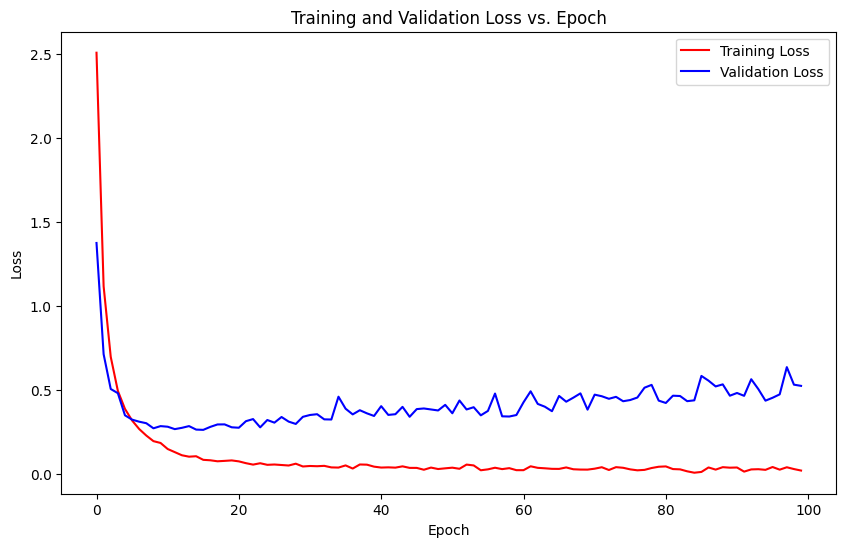

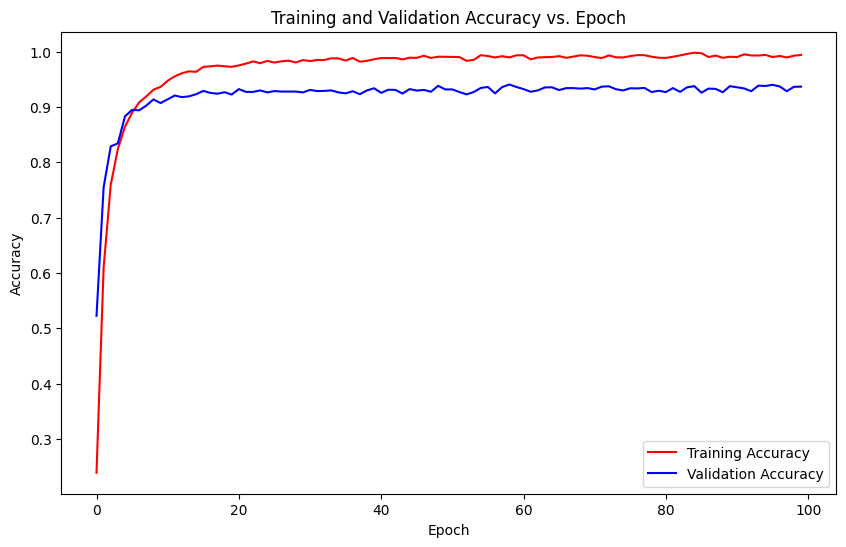

Elapsed time: 1181.9747450351715 seconds


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Record the start time
start_time = time.time()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(image_path, label_path):
    # Load datasets
    images = pd.read_csv(image_path, header=None).values
    labels = pd.read_csv(label_path, header=None).values

    # Reshape images to (num_samples, 1, 32, 32)
    images = images.reshape(-1, 1, 32, 32)

    # Normalize image data
    images = images.astype(np.float32) / 255.0

    # Convert labels to long type and zero-index them
    labels = torch.tensor(labels).long().squeeze()
    labels -= 1  # Subtract 1 if labels start from 1

    return torch.tensor(images), labels

class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        # First block of conv layers
        self.conv1 = nn.Conv2d(1, 128, kernel_size=7, padding=3)
        # Output size: (32-7+2*3)/1 + 1 = 32
        self.pool1 = nn.MaxPool2d(2, 2)  # Output size: 32/2 = 16

        # Second block of conv layers
        self.conv2 = nn.Conv2d(128, 256, kernel_size=7, padding=3)
        # Output size: (16-7+2*3)/1 + 1 = 16
        self.pool2 = nn.MaxPool2d(2, 2)  # Output size: 16/2 = 8

        # Third block of conv layers
        self.conv3 = nn.Conv2d(256, 512, kernel_size=7, padding=3)
        # Output size: (8-7+2*3)/1 + 1 = 8
        self.pool3 = nn.MaxPool2d(2, 2)  # Output size: 8/2 = 4

        # Calculate the size of the flattened layer
        self._to_linear = 512 * 4 * 4  # After pooling three times, the size is 4x4

        # Fully connected dense layers
        self.fc1 = nn.Linear(self._to_linear, 1024)

        # Dropout before the output layer
        self.dropout = nn.Dropout(0.5)

        # Output layer
        self.fc2 = nn.Linear(1024, 28)  # 28 classes for classification

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output
        x = torch.flatten(x, 1)

        # Forward pass through the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Load and preprocess training data
train_images, train_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv', 
    '/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv'
)

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTestImages 3360x1024.csv', 
    '/kaggle/input/visiondataset/csvTestLabel 3360x1.csv'
)

# Creating data loaders for training and testing data
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Create the model instance
model2 = CNNModel2().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters())

# Initialize lists to store losses and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    training_accuracies.append(accuracy)
    
    # Evaluating the model on the test set
    model2.eval()  # Set the model to evaluation mode
    test_accuracy = 0.0
    total_val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()  # Accumulate validation loss
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        avg_val_loss = total_val_loss / len(test_loader)  # Average validation loss

        validation_losses.append(avg_val_loss)
        validation_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], T Loss: {avg_loss:.4f}, T Accuracy: {accuracy:.4f}, V Loss: {avg_val_loss:.4f}, V Accuracy: {test_accuracy:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies on the same plot
plt.figure(figsize=(10, 6))

plt.plot(training_accuracies, label='Training Accuracy', color='red')
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

model2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print('Test accuracy is: {} %'.format(100 * correct / total))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))


Test accuracy is: 93.69047619047619 %
Precision: 0.9385
Recall: 0.9369
F1 Score: 0.9369


# Task 2: Data Augmentation

Epoch [1/50], T Loss: 2.5509, T Accuracy: 0.1760, V Loss: 1.2898, V Accuracy: 0.4517
Epoch [2/50], T Loss: 0.9931, T Accuracy: 0.5954, V Loss: 0.4967, V Accuracy: 0.8086
Epoch [3/50], T Loss: 0.4874, T Accuracy: 0.8248, V Loss: 0.3476, V Accuracy: 0.8842
Epoch [4/50], T Loss: 0.3273, T Accuracy: 0.8969, V Loss: 0.2663, V Accuracy: 0.9161
Epoch [5/50], T Loss: 0.2507, T Accuracy: 0.9242, V Loss: 0.2325, V Accuracy: 0.9294
Epoch [6/50], T Loss: 0.2075, T Accuracy: 0.9380, V Loss: 0.2350, V Accuracy: 0.9364
Epoch [7/50], T Loss: 0.1757, T Accuracy: 0.9468, V Loss: 0.2118, V Accuracy: 0.9377
Epoch [8/50], T Loss: 0.1598, T Accuracy: 0.9521, V Loss: 0.1947, V Accuracy: 0.9470
Epoch [9/50], T Loss: 0.1451, T Accuracy: 0.9567, V Loss: 0.2282, V Accuracy: 0.9432
Epoch [10/50], T Loss: 0.1345, T Accuracy: 0.9600, V Loss: 0.2160, V Accuracy: 0.9455
Epoch [11/50], T Loss: 0.1266, T Accuracy: 0.9621, V Loss: 0.2039, V Accuracy: 0.9490
Epoch [12/50], T Loss: 0.1113, T Accuracy: 0.9664, V Loss: 0.25

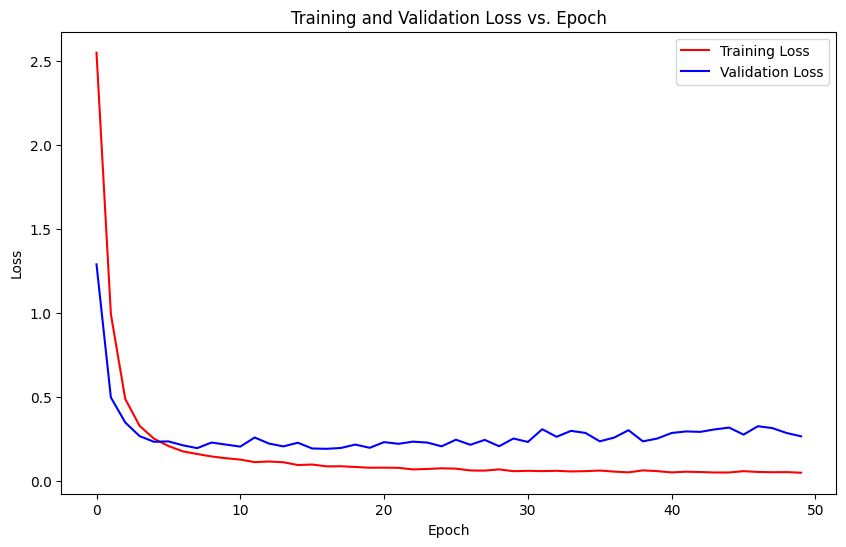

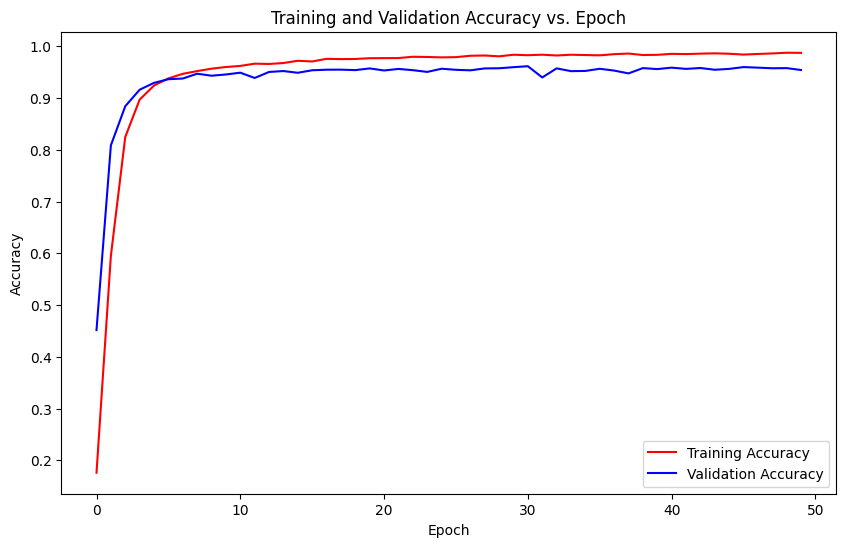

Elapsed time: 239.65830159187317 seconds


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

# Record the start time
start_time = time.time()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(image_path, label_path, augment=True, noise_level=0.1):
    # Load datasets
    images = pd.read_csv(image_path, header=None).values
    labels = pd.read_csv(label_path, header=None).values

    # Reshape images to (num_samples, 32, 32)
    images = images.reshape(-1, 32, 32).astype(np.uint8)  # Convert to uint8

    # Define augmentation transforms
    augmentation_transforms_contrast = transforms.Compose([
        ToPILImage(),
        transforms.ColorJitter(contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Add white noise
    def add_white_noise(img, noise_level):
        noise = noise_level * torch.randn_like(img)
        noisy_img = img + noise
        return torch.clamp(noisy_img, 0, 1)

    # Rotation augmentation
    augmentation_transforms_rotate = transforms.Compose([
        ToPILImage(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Normalization for non-augmented images
    normal_transforms = transforms.Compose([
        ToPILImage(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_white_noise(x, noise_level)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply transforms and concatenate
    augmented_images_contrast = torch.stack([augmentation_transforms_contrast(img) for img in images])
    augmented_images_rotate = torch.stack([augmentation_transforms_rotate(img) for img in images])
    normal_images = torch.stack([normal_transforms(img) for img in images])

    # Check if the sizes of all tensors are consistent
    assert normal_images.size(0) == augmented_images_contrast.size(0) == augmented_images_rotate.size(0) == labels.shape[0], "Size mismatch between tensors"

    all_images = torch.cat((normal_images, augmented_images_contrast, augmented_images_rotate), dim=0)
    all_labels = torch.tensor(np.concatenate([labels] * 3, axis=0)).long().squeeze()
    all_labels -= 1  # Subtract 1 if labels start from 1

    return all_images, all_labels

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First block of conv layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Second block of conv layers
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        # Third block of conv layers
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)

        # Fourth block of conv layers with dropout
        self.dropout1 = nn.Dropout(0.5)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, 3, padding=1)

        # Calculate the size of the flattened layer
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1, nn.ReLU(), self.conv2, nn.ReLU(), self.pool,
            self.conv3, nn.ReLU(), self.conv4, nn.ReLU(), self.pool,
            self.conv5, nn.ReLU(), self.conv6, nn.ReLU(), self.pool,
            self.dropout1,
            self.conv7, nn.ReLU(), self.conv8, nn.ReLU(), self.pool
        )
        self._get_conv_output_size([1, 32, 32])  # Example input size

        # Fully connected dense layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 256)

        # Dropout before the output layer
        self.dropout2 = nn.Dropout(0.5)

        # Output layer
        self.fc3 = nn.Linear(256, 28)  # 28 classes

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            input = torch.rand(shape).unsqueeze(0)
            output = self.convs(input)
            self._to_linear = int(np.prod(output.size()[1:]))

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.convs(x)

        # Flatten the output
        x = torch.flatten(x, 1)  # Flatten starting from the 1st dimension

        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Load and preprocess training data
train_images, train_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv', 
    '/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv'
)

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTestImages 3360x1024.csv', 
    '/kaggle/input/visiondataset/csvTestLabel 3360x1.csv'
)

# Creating data loaders for training and testing data
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Create the model instance
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to store losses and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    training_accuracies.append(accuracy)
    
    # Evaluating the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_accuracy = 0.0
    total_val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()  # Accumulate validation loss
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        avg_val_loss = total_val_loss / len(test_loader)  # Average validation loss

        validation_losses.append(avg_val_loss)
        validation_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], T Loss: {avg_loss:.4f}, T Accuracy: {accuracy:.4f}, V Loss: {avg_val_loss:.4f}, V Accuracy: {test_accuracy:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies on the same plot
plt.figure(figsize=(10, 6))

plt.plot(training_accuracies, label='Training Accuracy', color='red')
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print('Test accuracy is: {} %'.format(100 * correct / total))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))


Test accuracy is: 95.41666666666667 %
Precision: 0.9551
Recall: 0.9542
F1 Score: 0.9543


# Task 3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], T Loss: 1.1686, T Accuracy: 0.6170, V Loss: 0.3430, V Accuracy: 0.8922
Epoch [2/50], T Loss: 0.3175, T Accuracy: 0.8992, V Loss: 0.2203, V Accuracy: 0.9378
Epoch [3/50], T Loss: 0.2071, T Accuracy: 0.9353, V Loss: 0.1938, V Accuracy: 0.9432
Epoch [4/50], T Loss: 0.1746, T Accuracy: 0.9485, V Loss: 0.1704, V Accuracy: 0.9526
Epoch [5/50], T Loss: 0.1765, T Accuracy: 0.9478, V Loss: 0.2024, V Accuracy: 0.9531
Epoch [6/50], T Loss: 0.1498, T Accuracy: 0.9558, V Loss: 0.1900, V Accuracy: 0.9502
Epoch [7/50], T Loss: 0.1428, T Accuracy: 0.9594, V Loss: 0.2482, V Accuracy: 0.9493
Epoch [8/50], T Loss: 0.1423, T Accuracy: 0.9597, V Loss: 0.2446, V Accuracy: 0.9447
Epoch [9/50], T Loss: 0.1309, T Accuracy: 0.9640, V Loss: 0.1896, V Accuracy: 0.9567
Epoch [10/50], T Loss: 0.1262, T Accuracy: 0.9664, V Loss: 0.1874, V Accuracy: 0.9593
Epoch [11/50], T Loss: 0.1237, T Accuracy: 0.9655, V Loss: 0.2124, V Accuracy: 0.9521
Epoch [12/50], T Loss: 0.1353, T Accuracy: 0.9641, V Loss: 0.20

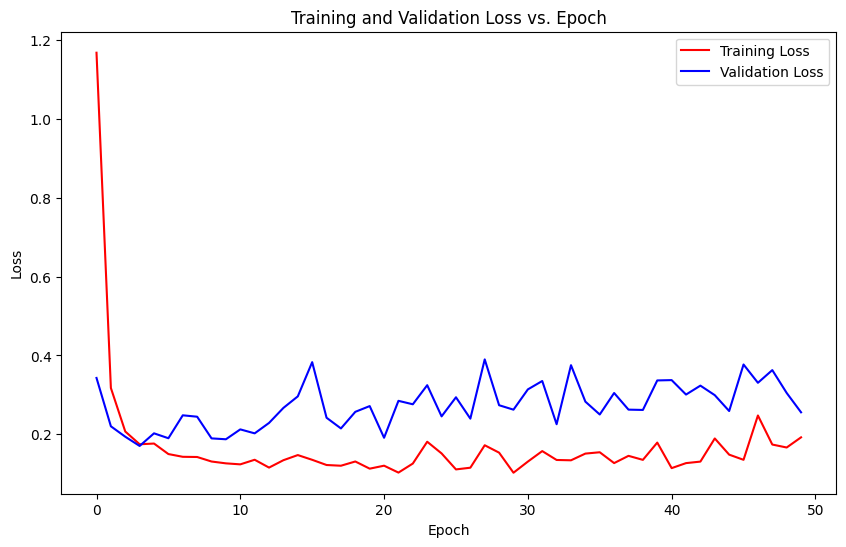

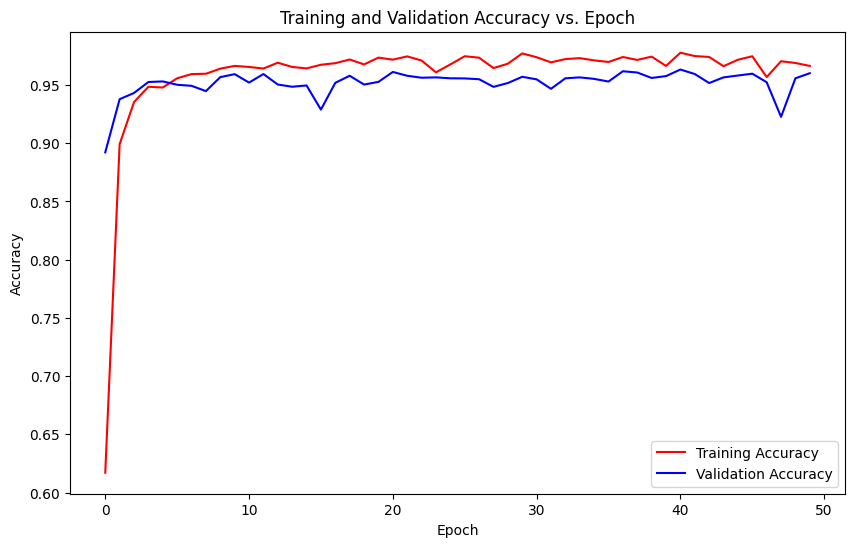

Elapsed time: 1410.8426072597504 seconds


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.models import alexnet

# Record the start time
start_time = time.time()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(image_path, label_path, augment=True):
    # Load datasets
    images = pd.read_csv(image_path, header=None).values
    labels = pd.read_csv(label_path, header=None).values

    # Reshape images to (num_samples, 32, 32)
    images = images.reshape(-1, 32, 32).astype(np.uint8)  # Convert to uint8

    # Resize images to (num_samples, 224, 224)
    resize_transform = transforms.Compose([
        ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    resized_images = torch.stack([resize_transform(img) for img in images])

    # Define custom white noise augmentation function
    def add_white_noise(img, noise_level):
        noise = noise_level * torch.randn_like(img)
        noisy_img = img + noise
        return torch.clamp(noisy_img, 0, 1)

    # Define augmentation transforms
    augmentation_transforms_contrast = transforms.Compose([
        ToPILImage(),
        transforms.ColorJitter(contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    augmentation_transforms_rotate = transforms.Compose([
        ToPILImage(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Normalization for non-augmented images
    normal_transforms = transforms.Compose([
        ToPILImage(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_white_noise(x, noise_level=0.1)),  # Apply white noise
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply transforms and concatenate
    augmented_images_contrast = torch.stack([augmentation_transforms_contrast(img) for img in resized_images])
    augmented_images_rotate = torch.stack([augmentation_transforms_rotate(img) for img in resized_images])
    normal_images = torch.stack([normal_transforms(img) for img in resized_images])

    # Check if the sizes of all tensors are consistent
    assert normal_images.size(0) == augmented_images_contrast.size(0) == augmented_images_rotate.size(0) == labels.shape[0], "Size mismatch between tensors"

    all_images = torch.cat((normal_images, augmented_images_contrast, augmented_images_rotate), dim=0)
    all_labels = torch.tensor(np.concatenate([labels] * 3, axis=0)).long().squeeze()
    all_labels -= 1  # Subtract 1 if labels start from 1

    return all_images, all_labels

# Use AlexNet as the model
class AlexNetModel(nn.Module):
    def __init__(self, num_classes=28):
        super(AlexNetModel, self).__init__()
        self.alexnet = alexnet(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        # Convert single-channel image to three channels
        x = torch.cat([x, x, x], dim=1)
        return self.alexnet(x)

# Load and preprocess training data
train_images, train_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv', 
    '/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv'
)

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTestImages 3360x1024.csv', 
    '/kaggle/input/visiondataset/csvTestLabel 3360x1.csv'
)

# Creating data loaders for training and testing data
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Create the AlexNet model instance
model = AlexNetModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to store losses and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    training_accuracies.append(accuracy)
    
    # Evaluating the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_accuracy = 0.0
    total_val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()  # Accumulate validation loss
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        avg_val_loss = total_val_loss / len(test_loader)  # Average validation loss

        validation_losses.append(avg_val_loss)
        validation_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], T Loss: {avg_loss:.4f}, T Accuracy: {accuracy:.4f}, V Loss: {avg_val_loss:.4f}, V Accuracy: {test_accuracy:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies on the same plot
plt.figure(figsize=(10, 6))

plt.plot(training_accuracies, label='Training Accuracy', color='red')
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print('Test accuracy is: {} %'.format(100 * correct / total))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))


Test accuracy is: 96.01190476190476 %
Precision: 0.9612
Recall: 0.9601
F1 Score: 0.9601


# Task 4

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-137

Epoch [1/50], T Loss: 1.0438, T Accuracy: 0.6679, V Loss: 0.6931, V Accuracy: 0.7786
Epoch [2/50], T Loss: 0.3972, T Accuracy: 0.8743, V Loss: 0.3459, V Accuracy: 0.8856
Epoch [3/50], T Loss: 0.2696, T Accuracy: 0.9182, V Loss: 0.2824, V Accuracy: 0.9107
Epoch [4/50], T Loss: 0.2040, T Accuracy: 0.9356, V Loss: 0.2898, V Accuracy: 0.9137
Epoch [5/50], T Loss: 0.1630, T Accuracy: 0.9498, V Loss: 0.2675, V Accuracy: 0.9177
Epoch [6/50], T Loss: 0.1417, T Accuracy: 0.9572, V Loss: 0.2152, V Accuracy: 0.9360
Epoch [7/50], T Loss: 0.1105, T Accuracy: 0.9651, V Loss: 0.3042, V Accuracy: 0.9189
Epoch [8/50], T Loss: 0.1158, T Accuracy: 0.9641, V Loss: 0.3562, V Accuracy: 0.9071
Epoch [9/50], T Loss: 0.0903, T Accuracy: 0.9738, V Loss: 0.2162, V Accuracy: 0.9446
Epoch [10/50], T Loss: 0.0832, T Accuracy: 0.9754, V Loss: 0.2359, V Accuracy: 0.9357
Epoch [11/50], T Loss: 0.0655, T Accuracy: 0.9796, V Loss: 0.2717, V Accuracy: 0.9281
Epoch [12/50], T Loss: 0.0621, T Accuracy: 0.9813, V Loss: 0.23

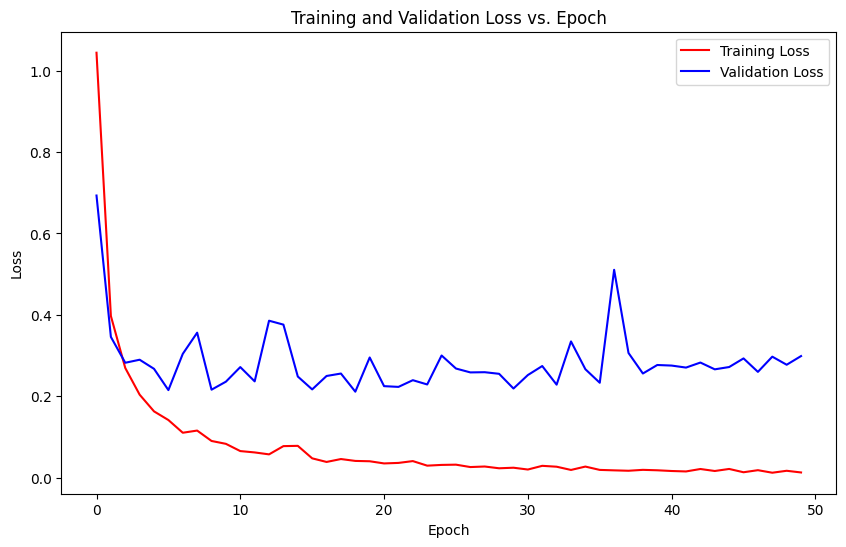

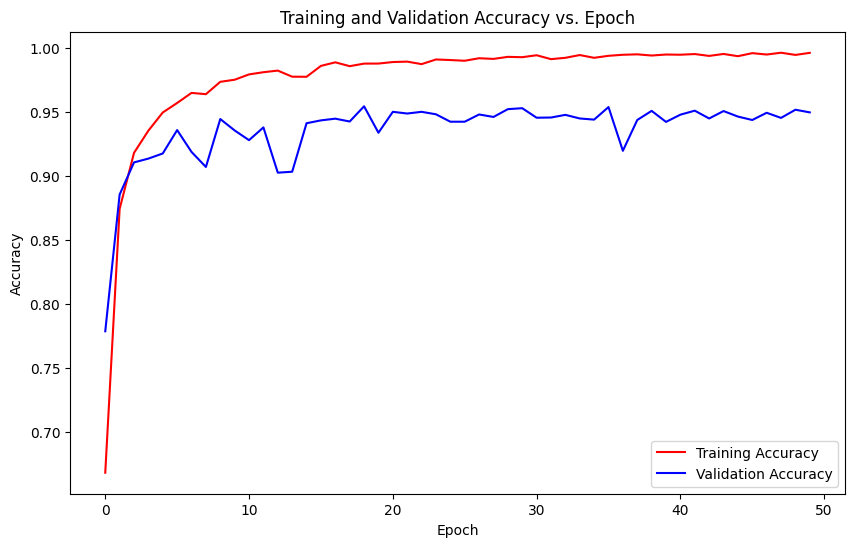

Elapsed time: 574.7351379394531 seconds


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

# Record the start time
start_time = time.time()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the FineTunedLeNet class
class FineTunedLeNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedLeNet, self).__init__()
        
        # Load the pre-trained LeNet model
        pretrained_lenet = models.googlenet(pretrained=True)
        # Modify the first layer to accept one channel
        pretrained_lenet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the last fully connected layer to match the number of classes in your dataset
        pretrained_lenet.fc = nn.Linear(pretrained_lenet.fc.in_features, num_classes)
        
        # Extract the required features from the pre-trained model
        self.features = nn.Sequential(*list(pretrained_lenet.children())[:-2])
        
        # Add a new fully connected layer for your task
        self.fc = nn.Linear(pretrained_lenet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def load_and_preprocess_data(image_path, label_path, augment=True, noise_level=0.1):
    # Load datasets
    images = pd.read_csv(image_path, header=None).values
    labels = pd.read_csv(label_path, header=None).values

    # Reshape images to (num_samples, 32, 32)
    images = images.reshape(-1, 32, 32).astype(np.uint8)  # Convert to uint8

    # Define augmentation transforms
    augmentation_transforms_contrast = transforms.Compose([
        ToPILImage(),
        transforms.ColorJitter(contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Add white noise
    def add_white_noise(img, noise_level):
        noise = noise_level * torch.randn_like(img)
        noisy_img = img + noise
        return torch.clamp(noisy_img, 0, 1)

    # Normalization for non-augmented images
    normal_transforms = transforms.Compose([
        ToPILImage(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_white_noise(x, noise_level)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply transforms and concatenate
    augmented_images_contrast = torch.stack([augmentation_transforms_contrast(img) for img in images])
    normal_images = torch.stack([normal_transforms(img) for img in images])

    # Check if the sizes of all tensors are consistent
    assert normal_images.size(0) == augmented_images_contrast.size(0) == labels.shape[0], "Size mismatch between tensors"

    all_images = torch.cat((normal_images, augmented_images_contrast), dim=0)
    all_labels = torch.tensor(np.concatenate([labels] * 2, axis=0)).long().squeeze()
    all_labels -= 1  # Subtract 1 if labels start from 1

    return all_images, all_labels
    
# Load and preprocess training data
train_images, train_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTrainImages 13440x1024.csv', 
    '/kaggle/input/visiondataset/csvTrainLabel 13440x1.csv'
)

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_data(
    '/kaggle/input/visiondataset/csvTestImages 3360x1024.csv', 
    '/kaggle/input/visiondataset/csvTestLabel 3360x1.csv'
)

# Creating data loaders for training and testing data
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Create the model instance
num_classes = 28  # Change this based on the number of classes in your dataset
model = FineTunedLeNet(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to store losses and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    training_accuracies.append(accuracy)
    
    # Evaluating the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_accuracy = 0.0
    total_val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()  # Accumulate validation loss
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        avg_val_loss = total_val_loss / len(test_loader)  # Average validation loss

        validation_losses.append(avg_val_loss)
        validation_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], T Loss: {avg_loss:.4f}, T Accuracy: {accuracy:.4f}, V Loss: {avg_val_loss:.4f}, V Accuracy: {test_accuracy:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies on the same plot
plt.figure(figsize=(10, 6))

plt.plot(training_accuracies, label='Training Accuracy', color='red')
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print('Test accuracy is: {} %'.format(100 * correct / total))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))


Test accuracy is: 94.98511904761905 %
Precision: 0.9521
Recall: 0.9499
F1 Score: 0.9498
